# Practical modeling
This is the notebook we filled during the course, but with additional comments to make it more self-contained.

The [jupyter notebook](https://jupyter-notebook.readthedocs.io/en/stable/) is an environment to execute code interactively, and to create a document that contains code and its ouput (including plots), as well as additional comments.

It consists of "code cells" (like the one above), starting with "`In [...]`" that contain Python code. These code cells can be executed by pressing "Shift + Return".
In the simplest case, these can be used like a calculator:

In [1]:
3 + 4

7

A document can also contain "markdown cells", cells with text comments that support simple formatting (see [basic markdown syntax](https://www.markdownguide.org/basic-syntax/)), embedding links, images, etc. Of particular use for us is the ability to include equations using LaTeX syntax (enclosed in $-signs). By double clicking on a markdown cell you can edit it, the "Shift + Return" combination that executes code cells will turn a markdown cell into nicely formatted text:

# Headings

* bullet
* points

Some text. *italics* or **bold**.

$\frac{dV}{dt} = \dots$

In [2]:
print("Hello")  # General Python code can be executed

Hello


In [3]:
from brian2 import *  # We import "everything" from the brian2 package
from brian2tools import brian_plot

In [4]:
# deactivate Brian's model → C++ code mechanism. Our models are too simple to benefit from this:
prefs.codegen.target = 'numpy'

# Part 1: Neurons

The basic equation for a leaky integrate-and-fire model:

$\frac{dV}{dt} = (g_L(E_L - V) + I_{stim})/C_m$ 

In [5]:
# The start_scope() is something that we only need when we run several Brian simulations in a single
# notebook or script. It means: "forget the models defined earlier". Without it, Brian would be confused
# when we call "run(...)", since there are several models that could be run.
start_scope()

# We can write down the above equation for Brian in a very similar way to the original equation
# The only Brian-specific syntax is the physical unit of the variable after the colon (here: volt for a voltage)
eqs = "dV/dt = (g_L*(E_L - V) + I_stim)/C_m : volt"
# The constants that are used in the above equations can be defined as Python variables
# Brian provides the units (nF, mV, nS, nA, ...) and knows how to combine/convert between them
C_m = 0.4*nF
E_L = -70*mV
g_L = 20*nS
I_stim = 0.44*nA

# Now we put all the components together to create a group of neurons (here with a single neuron).
# In addition to the equations, we also define a threshold condition and a reset statement.
# method='exact' means to integrate the equations using their analytical solution (only possible for
# simple equations). Other possible choices are e.g. 'euler' (forward Euler method, very fast but not
# accurate/stable) or 'rk4' (4th order Runge-Kutta method, very accurate but slow)
neurons = NeuronGroup(1, model=eqs, threshold="V > -50*mV",
                      reset="V = -90*mV", method='exact')
# All variables of our model (here, "V" is the only variable) are available as attributes of the NeuronGroup
# object. We can ask for their values or set them to set the initial conditions at the start of the simulation
neurons.V = E_L

# To record the values of variables during a simulation, we need a "StateMonitor". Its arguments are
# "which group to record from", "which variable to record", "which neurons to record from".
state_mon = StateMonitor(neurons, "V", record=True)  # True = all neurons
# To record the information about which neuron spiked when, we use a SpikeMonitor
spike_mon = SpikeMonitor(neurons)

# Now we are ready to run the simulation
run(500*ms)

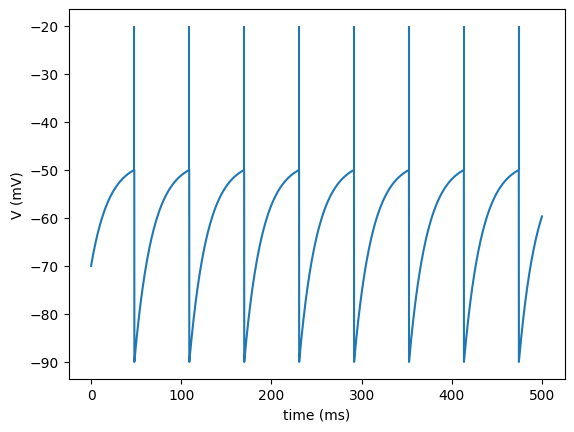

In [6]:
# Plot the membrane potential of the 1st neuron (neuron with index 0) in mV against the time of the recordings
# in ms
brian_plot(state_mon)

# Plot vertical lines from -50mV to -20mV for each spike
plt.vlines(spike_mon.t/ms,
           np.ones(spike_mon.count[0])*-50,
           np.ones(spike_mon.count[0])*-20);  # ← we can put a semicolon to avoid text output
                                              #   from plotting functions

What would be the equilibrium membrane potential, if we did not have a threshold?
\begin{align}
0 &= g_L (E_L - V) + I_{stim}\\
-I_stim/g_L &= E_L - V\\
-I_stim/g_L - E_L &= -V\\
V &= I_{stim}/g_L + E_L
\end{align}

In [7]:
I_stim/g_L + E_L

-48. * mvolt

What is the current needed to get the neuron to spike?
\begin{align}
V_{th} &= I_{stim}/g_L + E_L\\
I_{stim} &= g_L(V_{th} - E_L)
\end{align}

In [8]:
g_L*(-50*mV -E_L)

0.4 * namp

We now turn our differential equation into a [stochastic differential equation](https://en.wikipedia.org/wiki/Stochastic_differential_equation), by including a noise term. This is meant to make our model a bit
more "realistic", since biological neurons are not perfectly smooth machines.
Do not worry too much about the scaling with the $\sqrt(2/\tau)$ term, this is necessary for dimensional
correctness (some remarks about this in the [Brian documentation](https://brian2.readthedocs.io/en/stable/user/models.html#time-scaling-of-noise)).

$\frac{dV}{dt} = (g_L(E_L - V) + I_{const})/C_m + \sigma\sqrt{2/\tau}\xi$ 

The time constant $\tau=C_m/g_L$ determines how fast the neuron reacts to changes in its input. 

In [9]:
tau = C_m/g_L
tau

20. * msecond

In [10]:
start_scope()

# The equation refers to "xi", which is the predefined noise term ξ
eqs = "dV/dt = (g_L*(E_L - V) + I_stim)/C_m + sigma*sqrt(2/tau)*xi: volt"
C_m = 0.4*nF
E_L = -70*mV
g_L = 20*nS
I_stim = 0.44*nA
sigma = 0.3*mV
tau = C_m/g_L

neurons = NeuronGroup(1, model=eqs, threshold="V > -50*mV",
                      reset="V =-90*mV", method='euler')
neurons.V = E_L

state_mon = StateMonitor(neurons, "V", record=True)  # True = all neurons
spike_mon = SpikeMonitor(neurons)

run(500*ms)

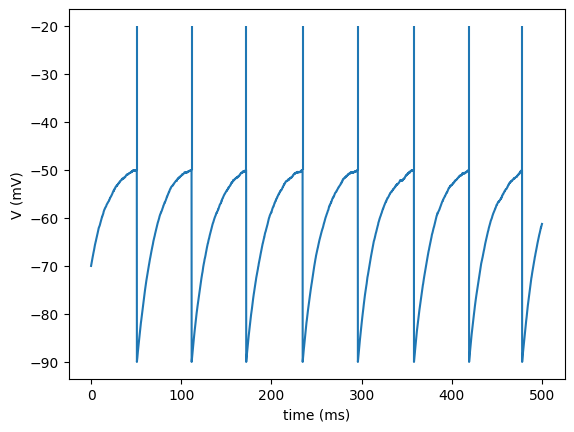

In [11]:
# If you look closely, you see that the lines are a bit "wiggly" now
brian_plot(state_mon)
plt.vlines(spike_mon.t/ms,
           np.ones(spike_mon.count[0])*-50,
           np.ones(spike_mon.count[0])*-20);

We can now reproduce the observation by Mainen & Sejnowski (1995) that a neuron spikes unreliably (different spike times in repeated trials) when stimulated with a constant current. Instead of running the simulation 25 times for a single neuron, we simulate a group of 25 independent neurons at once – this gives the exact same results (since all neurons are perfectly identical), but is a bit more compact to write and more efficient to simulate.

In [12]:
start_scope()

eqs = "dV/dt = (g_L*(E_L - V) + I_stim)/C_m + sigma*sqrt(2/tau)*xi: volt"
C_m = 0.4*nF
E_L = -70*mV
g_L = 20*nS
I_stim = 0.44*nA
sigma = 0.3*mV
tau = C_m/g_L

neurons = NeuronGroup(25, model=eqs, threshold="V > -50*mV",
                      reset="V = E_L", method='euler')
neurons.V = E_L

state_mon = StateMonitor(neurons, "V", record=True)  # True = all neurons
spike_mon = SpikeMonitor(neurons)

run(500*ms)

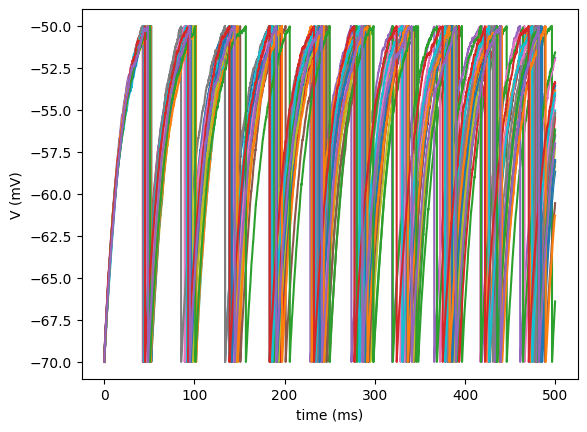

In [13]:
brian_plot(state_mon);

As we can see, initially the membrane potential trajectory is very similar across neurons, but quickly it starts to drift and become different. We can see the same in a raster plot:

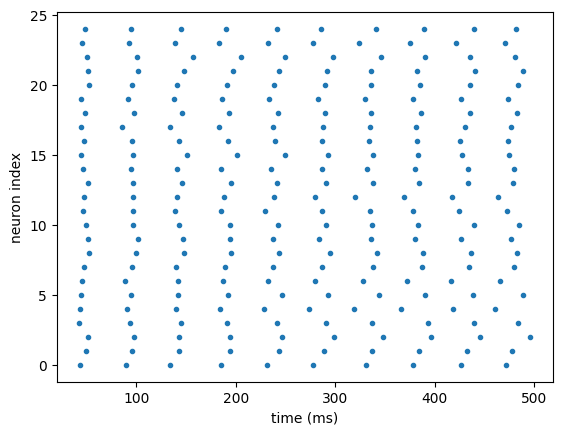

In [14]:
brian_plot(spike_mon);

Now, let us reproduce the second part of the experiment, i.e. the response of a neuron to a fluctuating input current. We can use Brian's equation machinery to generate this noise stimulus, it is not restricted to only model neurons and their properties. We generate a random input current first:

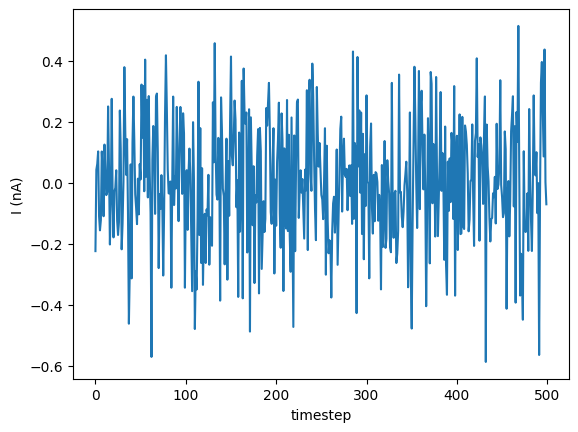

In [15]:
random_current = np.random.randn(500)*0.2*nA
plt.plot(random_current/nA)
plt.ylabel('I (nA)')
plt.xlabel('timestep');

In [16]:
start_scope()
# We make the simulation reproducible by setting a random seed
seed(183)

# By wrapping the noise current in a "TimedArray", we can access it in the equations as a function of time
random_current = np.random.randn(500)*0.2*nA
I_noise = TimedArray(random_current, dt=1*ms)

# We add the fluctuating current to the constant current, so the mean input current will be the same as
# before – the new current fluctuates around the value of the constant current.
eqs = """dV/dt = (g_L*(E_L - V) + I_stim + I_noise(t))/C_m +
                 sigma*sqrt(2/tau)*xi: volt
      """
C_m = 0.4*nF
E_L = -70*mV
g_L = 20*nS
I_stim = 0.44*nA
sigma = 0.3*mV
tau = C_m/g_L

neurons = NeuronGroup(25, model=eqs, threshold="V > -50*mV",
                      reset="V = -90*mV", method='euler')
neurons.V = E_L

state_mon = StateMonitor(neurons, "V", record=True)  # True = all neurons
spike_mon = SpikeMonitor(neurons)

run(500*ms)

Now, the membrane potential traces over trials look much more similar. And instead of slowly drifting and becoming more different over time, differences are temporary and neurons will "realign" at a later stage:

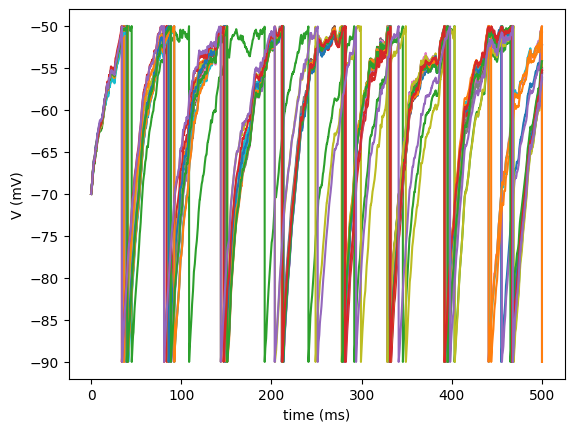

In [17]:
brian_plot(state_mon);

<Axes: xlabel='time (ms)', ylabel='neuron index'>

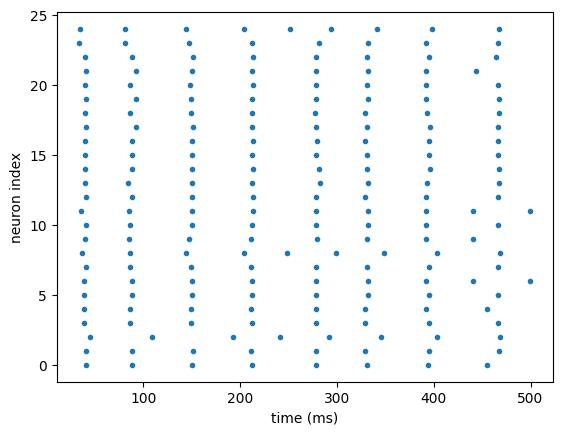

In [18]:
brian_plot(spike_mon)

# Part 2: networks

Let us look at how a neuron in cortex, which receives input from many other neurons, integrates the inputs and whether we can see a difference between a mean-driven and a fluctuation-driven regime. As an input source, we use a group of simplified "Poisson neurons", i.e. neurons that aren't modeled in any detail, but simply emit spikes according to a [Poisson process](https://en.wikipedia.org/wiki/Poisson_point_process):

In [19]:
start_scope()

input_spikes = PoissonGroup(100, rates=2/second)
inp_monitor = SpikeMonitor(input_spikes)

run(1000*ms)

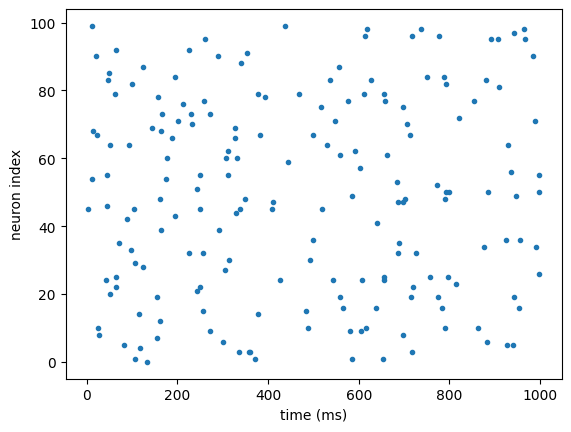

In [20]:
brian_plot(inp_monitor);

In [21]:
start_scope()

poisson_spikes = PoissonGroup(10000, rates=2/second)

# We now include a synaptic current in our neuron model, which replaces the previous constant/fluctuating
# currents. In the absence of any incoming spikes, it goes back to 0 with time constant tau_syn:
tau_syn = 5*ms
eqs = """dV/dt = (g_L*(E_L - V) + I_syn)/C_m: volt
         dI_syn/dt = -I_syn/tau_syn : amp
      """
C_m = 0.4*nF
E_L = -70*mV
g_L = 20*nS

neurons = NeuronGroup(1, model=eqs, threshold="V > -50*mV",
                      reset="V = -90*mV", method='euler')
neurons.V = E_L

# We now create a description of our Synapses. In complicated models (synaptic plasticity, etc.), we'd have
# equations describing the synapses. Here, we only state that "on the arrival of an incoming pre-synaptic spike"
# ("on_pre"), increase the post-synaptic current I_syn by 0.01nA:
synapses = Synapses(poisson_spikes, neurons,
                    on_pre='I_syn += 0.01*nA')
# Our target group here only has a single neuron, but in more complex networks we'd now decide how to connect
# neurons in the source group to neurons in the target group (e.g. all-to-all, or with certain rules based e.g. on
# their distance, or randomly with a given probability, etc.). Here we simply call "connect()" which connects
# all neurons in the source group to "all" (there's only one) neurons in the target group.
synapses.connect()

state_mon = StateMonitor(neurons, "V", record=True)
# in addition to V, we also record the synaptic current I_syn
current_mon = StateMonitor(neurons, 'I_syn', record=True)

spike_mon = SpikeMonitor(neurons)

run(1000*ms)

mean current: 0.9941703 nA


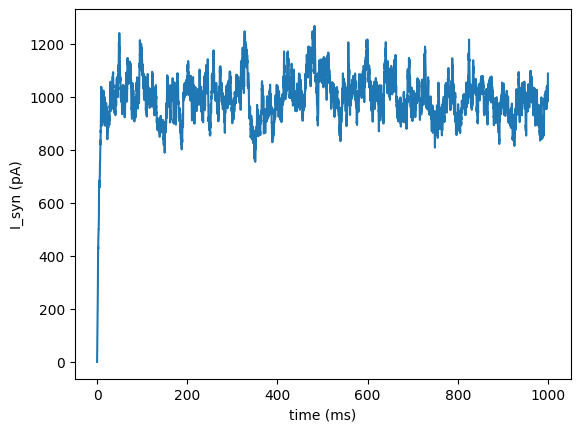

In [22]:
brian_plot(current_mon)
print("mean current:", np.mean(current_mon.I_syn[0]))

The input that the neuron receives is fairly constant (due to the large number of incoming spikes), and its mean is
well above the threshold of the neuron. As a consequence, the neuron fires regularly:

(0.0, 200.0)

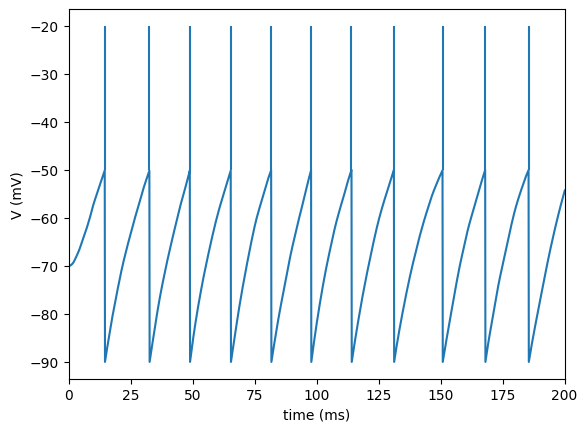

In [23]:
brian_plot(state_mon)
plt.vlines(spike_mon.t/ms,
           np.ones(spike_mon.count[0])*-50,
           np.ones(spike_mon.count[0])*-20)
plt.xlim(0, 200)  # focussing on the first 200ms for a clearer picture

In the above "network", there were only excitatory connections. Real neurons recieve both excitatory and inhibitory input. In cortex, about 80% of the cells are excitatory and 20% are inhibitory, but this is partly compensated by the fact that inhibitory connections tend to be stronger. Let's separate our input "neurons" and divide them into excitatory and inhibitory, which get connected with corresponding connections to our target neuron:

In [24]:
start_scope()

input_spikes = PoissonGroup(10000, rates=2*Hz)
exc_spikes = input_spikes[0:8000]  # The first 8000 neurons are considered excitatory
inh_spikes = input_spikes[8000:10000]  # The last 2000 neurons are considered inhibitory

tau_syn = 5*ms
eqs = """dV/dt = (g_L*(E_L - V) + I_syn)/C_m: volt
         dI_syn/dt = -I_syn/tau_syn : amp
      """
C_m = 0.4*nF
E_L = -70*mV
g_L = 20*nS

neurons = NeuronGroup(1, model=eqs, threshold="V > -50*mV",
                      reset="V = E_L", method='euler')
neurons.V = E_L
exc_synapses = Synapses(exc_spikes, neurons,
                    on_pre='I_syn += 0.02*nA')
exc_synapses.connect()
# Inhibitory neurons are modeled in the same way as excitatory neurons, but with stronger (and negative) weight
inh_synapses = Synapses(inh_spikes, neurons,
                    on_pre='I_syn -=  0.0625*nA')
inh_synapses.connect()

state_mon = StateMonitor(neurons, "V", record=True)
current_mon = StateMonitor(neurons, 'I_syn', record=True)
spike_mon = SpikeMonitor(neurons)

run(1000*ms)

mean current: 0.33388597 nA


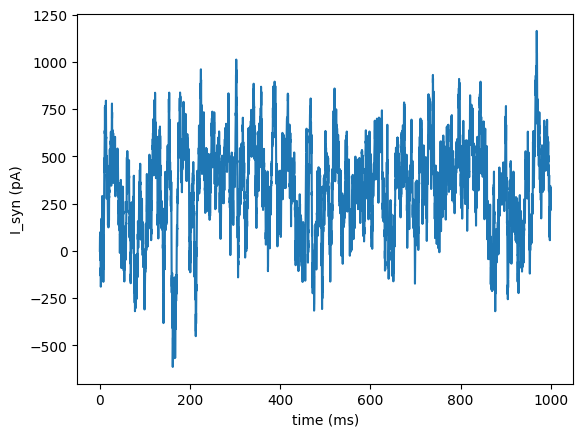

In [25]:
brian_plot(current_mon)
print("mean current:", np.mean(current_mon.I_syn[0]))

The total received input is now much weaker (and more variable), leading to a neuron that fires irregularly:

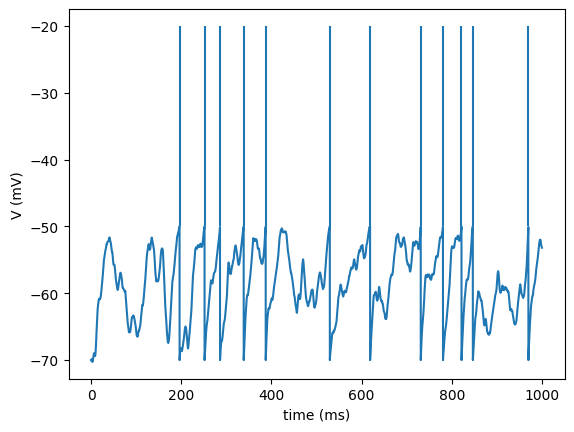

In [26]:
brian_plot(state_mon)
plt.vlines(spike_mon.t/ms,
           np.ones(spike_mon.count[0])*-50,
           np.ones(spike_mon.count[0])*-20);

Instead of simulating a single neuron with random external input, let's simulate a network of cells that connect to each other. Since without any external input, no neuron would spike, we additionally add a (super-threshold) input current.

In [27]:
start_scope()

eqs = """dV/dt = (g_L*(E_L - V) + I_syn + I_stim)/C_m : volt
         dI_syn/dt = -I_syn/tau_syn : amp"""
tau_syn = 5*ms
C_m = 0.4*nfarad # nF
E_L = -70*mvolt  # mV
g_L = 20*nsiemens # nS
I_stim = 0.44*nA

neurons = NeuronGroup(1000, model=eqs, threshold='V > -50*mV', reset='V = -90*mV', method='euler')
# If all neurons start with the same membrane potential, the common constant input current would make
# all of them spike at exactly the same time. To avoid this artificial synchronization at the beginning
# of the simulation, we initialize the membrane potential to a random value for each cell
# (between -70mV and -50mV)
neurons.V = "E_L + rand()*20*mV"
exc_neurons = neurons[:800]
inh_neurons = neurons[800:]

# We connect the 800 excitatory neurons to all neurons with excitatory synapses, but only connect each
# possible pair of connections with a probability of 2% (i.e. each neuron receives on average 800×0.02=16
# excitatory inputs)
exc_synapses = Synapses(exc_neurons, neurons, on_pre='I_syn_post += 100*pA')
exc_synapses.connect(p=0.02)

# We do the same for the inhibitory neurons. Since there are fewer inhibitory neurons, each neuron will
# only receive 4 inhibitory inputs on average.
inh_synapses = Synapses(inh_neurons, neurons, on_pre='I_syn_post -= 200*pA')
inh_synapses.connect(p=0.02)

state_mon = StateMonitor(neurons, 'V', record=True)
current_mon = StateMonitor(neurons, 'I_syn', record=True)
spike_mon = SpikeMonitor(neurons)

run(1*second, report='text')

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in < 1s


Without the network connections, all neurons would fire regularly with the same rate. Due to the input from the network (and the random connectivity), the neurons fire asynchronously and irregularly:

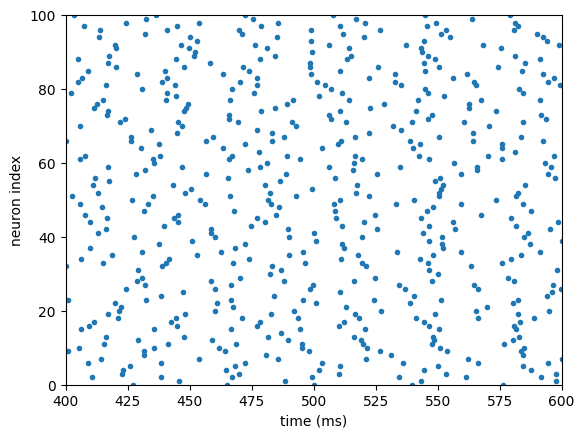

In [28]:
brian_plot(spike_mon);
# Zoom in on a subset of cells and time
plt.xlim(400, 600)
plt.ylim(0, 100);